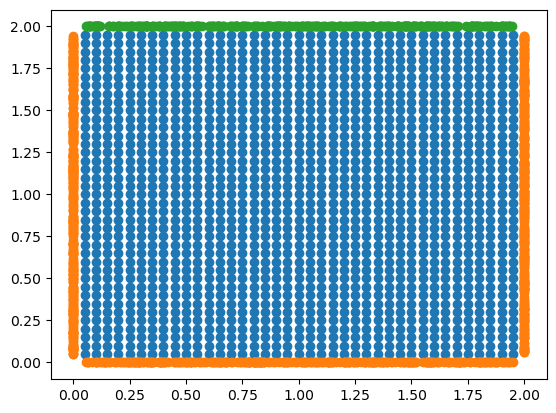

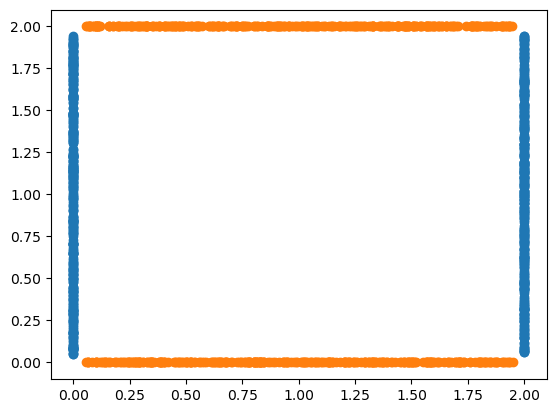

In [7]:
import sys
sys.path.append('../')

import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import matplotlib

from user_funn.field import D2Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.geom import line_sample
import user_funn.plot
from user_funn.get_net import DataNetwork

np.random.seed(1)
torch.manual_seed(1)

# STEP1 data generate
batch_num = 1 #ATTENSION: error calculate batch_size when batch_num != 1
nx = 41

field = D2Field([0,2],[0,2])
pde_batch_size = (nx-2) * (nx-2) 
pde_epoch_size = pde_batch_size * batch_num
pde_input = field.get_field_mesh([nx,nx])
filter = [True if (0.04<=item[0]<=1.96 and 0.04<=item[1]<=1.96) else False \
    for item in pde_input ]
pde_input = pde_input[filter]
pde_output = np.zeros([pde_epoch_size,3])

"""
bc_uv_zero[...]
bc_dpdx_zero[...]: left + right
bc_dpdy_zero[...]: up + down
"""

each_line_batch_point = nx * 8 #每条边上用点数量
each_line_point = each_line_batch_point * batch_num

bc_left_input = line_sample([0,0.05], [0,1.95], each_line_point)
bc_up_input = line_sample([0.05,2], [1.95,2], each_line_point)
bc_right_input = line_sample([2,1.95], [2,0.05], each_line_point)
bc_down_input = line_sample([1.95,0], [0.05,0], each_line_point)

bc_uv_zero_input = np.vstack([bc_left_input, bc_down_input, bc_right_input])
bc_uv_up_input = bc_up_input 
bc_dpdx_zero_input = np.vstack([bc_left_input, bc_right_input])
bc_dpdy_zero_input = np.vstack([bc_up_input, bc_down_input])

bc_uv_zero_output = np.zeros([bc_uv_zero_input.shape[0], 2])
bc_uv_up_output = np.zeros([bc_uv_up_input.shape[0], 2])
bc_uv_up_output[:,0] = 1
bc_dpdx_zero_output = np.zeros([bc_dpdx_zero_input.shape[0], 1])
bc_dpdy_zero_output = np.zeros([bc_dpdy_zero_input.shape[0], 1])

bc_uv_zero_batchsize = bc_uv_zero_input.shape[0]
bc_uv_up_batchsize = bc_uv_up_input.shape[0]
bc_dpdx_zero_batchsize = bc_dpdx_zero_input.shape[0] 
bc_dpdy_zero_batchsize = bc_dpdy_zero_input.shape[0] 

user_funn.plot.scatter_2d_cloud_point_kind([pde_input, bc_uv_zero_input, \
    bc_uv_up_input])

user_funn.plot.scatter_2d_cloud_point_kind([bc_dpdx_zero_input, \
    bc_dpdy_zero_input])




In [8]:
loss_fn = torch.nn.MSELoss()

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

DX = 0.05
def pde_loss(model, data):
    x_in,y_real = data
    U = model(x_in)

    # 点赋值
    center_U = U[0,:,:]
    up_U = U[1,:,:]
    down_U = U[2,:,:]
    left_U = U[3,:,:]
    right_U = U[4,:,:]
    # 物理量
    p = center_U[:,0]
    u = center_U[:,1]
    v = center_U[:,2]
    # 导数计算
    dUdx = (right_U - left_U)/(DX*2)
    dUdy = (up_U - down_U)/(DX*2)
    d2Udx2 = (left_U - 2*center_U + right_U)/(DX*DX)
    d2Udy2 = (up_U - 2*center_U + down_U)/(DX*DX)
    # 一阶导
    dpdx = dUdx[:,0]
    dpdy = dUdy[:,0]
    dudx = dUdx[:,1]
    dudy = dUdy[:,1]
    dvdx = dUdx[:,2]
    dvdy = dUdy[:,2]
    # 二阶导
    d2pdx2 = d2Udx2[:,0]
    d2pdy2 = d2Udy2[:,0]
    d2udx2 = d2Udx2[:,1]
    d2udy2 = d2Udy2[:,1]
    d2vdx2 = d2Udx2[:,2]
    d2vdy2 = d2Udy2[:,2]

    eq1 = u*dudx + v*dudy + dpdx - 0.01*(d2udx2 + d2udy2)
    eq2 = u*dvdx + v*dvdy + dpdy - 0.01*(d2vdx2 + d2vdy2)
    eq3 = dudx + dvdy
    
    loss_val = loss_fn(eq1, y_real[:,0]).sqrt() + 0.5*eq1.abs().max() + \
        loss_fn(eq2, y_real[:,1]).sqrt() + 0.5*eq2.abs().max() + \
        loss_fn(eq3, y_real[:,2]).sqrt() + 0.5*eq3.abs().max()
    
    # loss_val = loss_fn(eq1, y_real[:,0]) + loss_fn(eq2, y_real[:,1]) + loss_fn(eq3, y_real[:,2])
    return loss_val

def bc_uv_zero_loss(model, data):
    x_in,y_real = data
    U = model(x_in)
    center_U = U[0,:,:]
    u = center_U[:,1]
    v = center_U[:,2]
    return (loss_fn(u, y_real[:,0]).sqrt() + loss_fn(v, y_real[:,1]).sqrt() + 0.5*u.abs().max())/3


def bc_uv_up_loss(model, data):
    x_in,y_real = data
    U = model(x_in)
    center_U = U[0,:,:]
    u = center_U[:,1]
    v = center_U[:,2]
    return (loss_fn(u, y_real[:,0]).sqrt() + loss_fn(v, y_real[:,1]).sqrt() + 0.5*v.abs().max())/3

def bc_dpdx_zero_loss(model, data):
    x_in,y_real = data
    U = model(x_in)
    # 点赋值
    center_U = U[0,:,:]
    left_U = U[3,:,:]
    right_U = U[4,:,:]
    # 物理量
    p = center_U[:,0]
    # 导数计算
    dUdx = (right_U - left_U)/(DX*2)
    dpdx = dUdx[:,0]
    return loss_fn(dpdx, y_real[:,0])


def bc_dpdy_zero_loss(model, data):
    x_in,y_real = data
    U = model(x_in)
    # 点赋值
    center_U = U[0,:,:]
    up_U = U[1,:,:]
    down_U = U[2,:,:]
    # 物理量
    p = center_U[:,0]
    # 导数计算
    dUdy = (up_U - down_U)/(DX*2)
    dpdy = dUdy[:,0]
    return loss_fn(dpdy, y_real[:,0])

cloud_point_data = [
    [pde_input, pde_output],
    [bc_uv_zero_input, bc_uv_zero_output],
    [bc_uv_up_input, bc_uv_up_output],
    [bc_dpdx_zero_input, bc_dpdx_zero_output],
    [bc_dpdy_zero_input, bc_dpdy_zero_output],
    ]

solver = CloudPointSolver(
    cloud_point_data,
    [pde_loss, bc_uv_zero_loss, bc_uv_up_loss, \
        bc_dpdx_zero_loss, bc_dpdy_zero_loss],
    model = DataNetwork([2, 100, 100, 100, 100, 3]),
    optimizer = "adam",
    batchsize = [pde_batch_size, bc_uv_zero_batchsize, bc_uv_up_batchsize,\
        bc_dpdx_zero_batchsize, bc_dpdy_zero_batchsize])

for i in range(50000):
    solver.train_step()
    if i % 1000 == 0:
        solver.test_step(print_flag=True)
print('train over')

loss is [6.2178924e-07 4.3972068e-02 3.8873440e-01 5.1364739e-15 4.2225706e-15
 4.3270710e-01]
loss is [7.5065657e-07 1.2461886e-04 3.3345091e-01 1.3031581e-15 2.0732061e-15
 3.3357629e-01]
loss is [6.1988343e-05 2.7321535e-04 3.3300644e-01 1.1654826e-10 2.8107186e-10
 3.3334166e-01]
loss is [3.2221656e-02 1.7398918e-01 2.3289016e-02 6.4432956e-05 1.7039298e-05
 2.2958131e-01]
loss is [1.9665536e-02 1.6314821e-01 2.5780931e-02 1.4609779e-04 8.7159342e-06
 2.0874949e-01]
loss is [1.0195568e-02 1.4125273e-01 3.6904097e-02 3.8320324e-04 9.4099778e-06
 1.8874499e-01]
loss is [1.35292578e-02 1.24958426e-01 4.44099605e-02 7.44691934e-04
 3.68486690e-05 1.83679178e-01]
loss is [1.6526178e-02 1.1571586e-01 4.7895543e-02 1.1837169e-03 4.7686979e-05
 1.8136898e-01]
loss is [2.1574646e-02 1.0329650e-01 6.1369758e-02 1.6205150e-03 5.2987147e-05
 1.8791442e-01]
loss is [9.72278509e-03 1.05248004e-01 5.16159199e-02 2.07286677e-03
 8.29885248e-05 1.68742567e-01]
loss is [1.4080538e-02 1.0142438e-01 5

0.4296424892020331
0.17733367536894726
0.5344689627165762


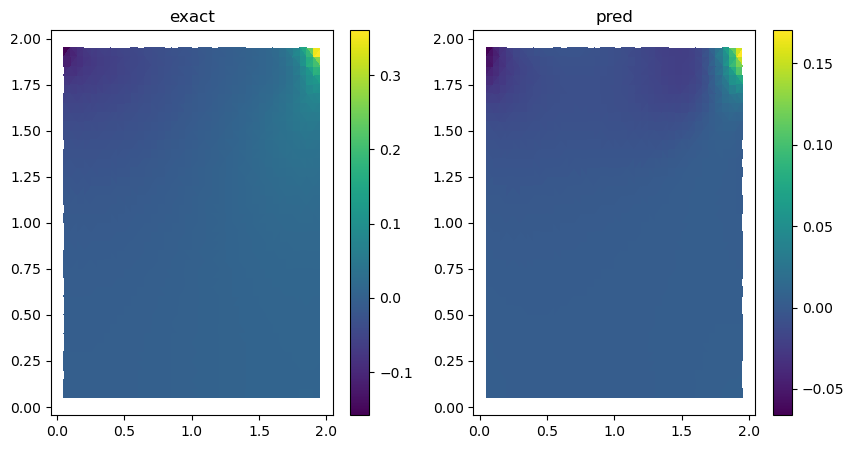

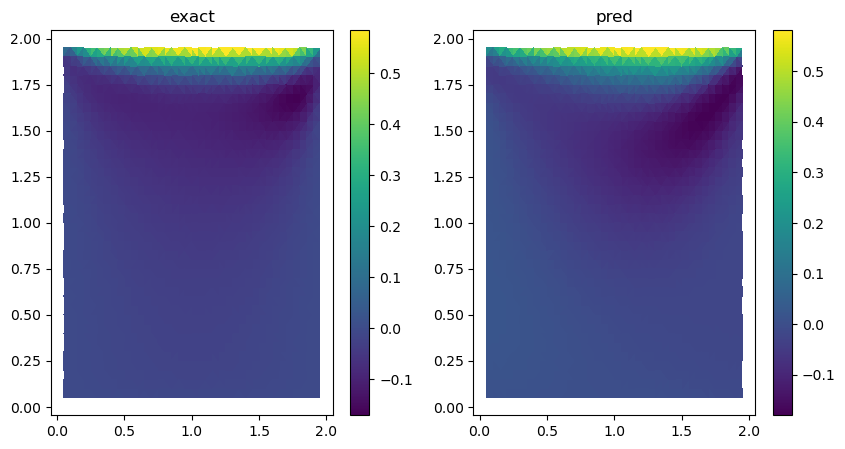

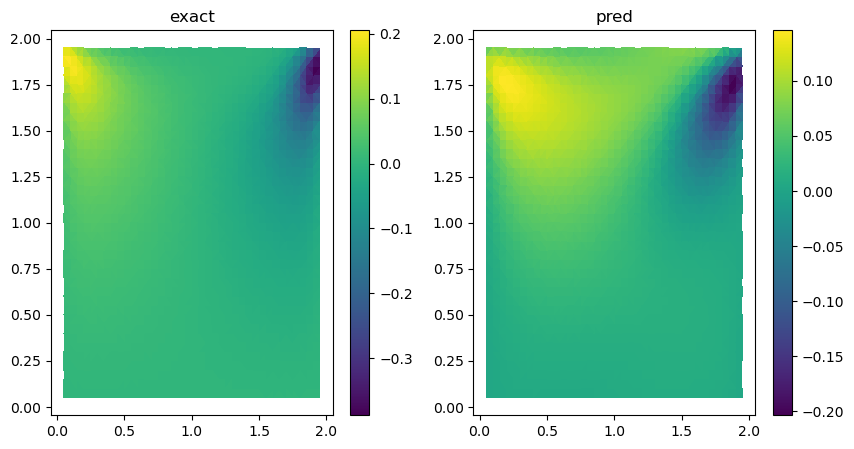

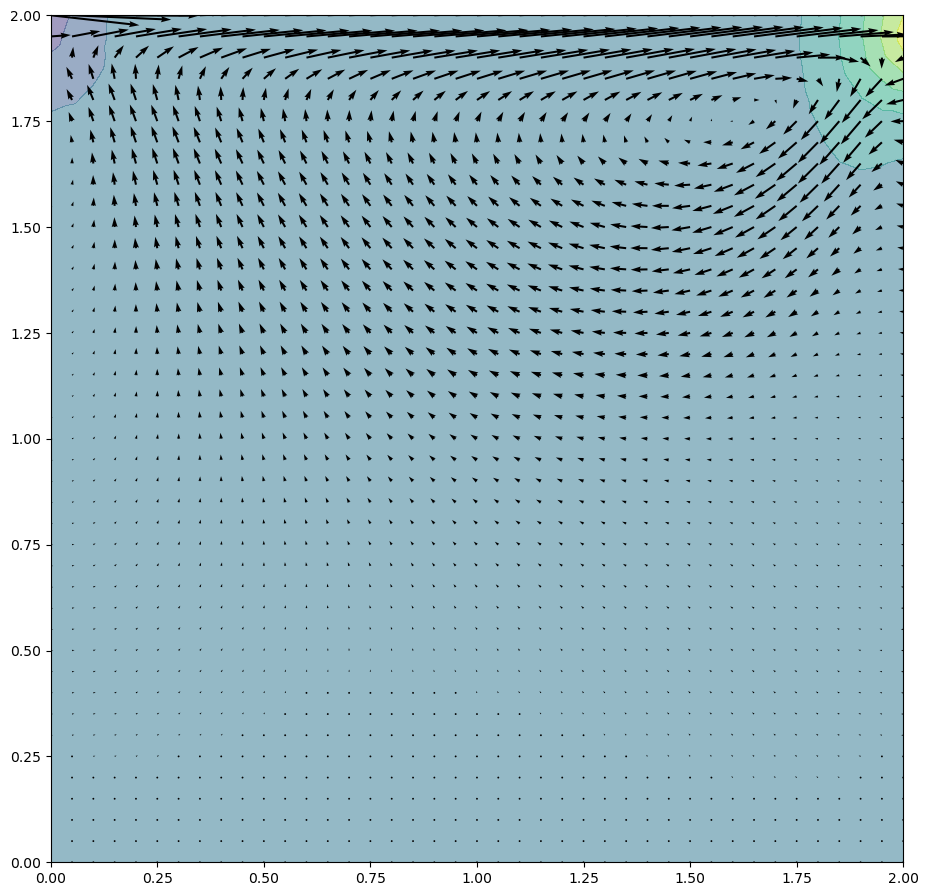

In [9]:
from user_funn.paraview_read import read2D_paraview_csv
exact_x,exact_y,exact_p,exact_u,exact_v=read2D_paraview_csv('../data/0.01result.csv',1)
plot_input = np.array([exact_x,exact_y]).T
plot_output = solver.model_eval(plot_input).detach().cpu().numpy()
plot_p = plot_output[0,:,0]
plot_u = plot_output[0,:,1]
plot_v = plot_output[0,:,2]

import matplotlib.pyplot as plt
import matplotlib.tri as tri                                                                                
def plot_U(x,y,u_exact,u_pred):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize =[10,5] )

    triang = tri.Triangulation(x,y)
    tpc = ax1.tripcolor(triang,u_exact , shading='flat')
    fig.colorbar(tpc,ax=ax1)
    ax1.set_title('exact')

    tpc = ax2.tripcolor(triang,u_pred , shading='flat')
    fig.colorbar(tpc,ax=ax2)
    ax2.set_title('pred')
    print(np.mean(np.abs(u_exact-u_pred))/np.std(u_exact))

x = plot_input[:,0]
y = plot_input[:,1]
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_p[filter]-np.mean(exact_p), plot_p[filter]-np.mean(plot_p))
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_u[filter], plot_u[filter])
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_v[filter], plot_v[filter])

plot_x = plot_input[:,0]
plot_y = plot_input[:,1]
plt.figure(figsize=(11, 11))
plt.tricontourf(plot_x, plot_y, plot_p,alpha=0.5, cmap=cm.viridis)
plt.quiver(plot_x, plot_y,plot_u,plot_v)
